# Model calibration using the equilibria

This is the module that using a predefined "equilibrium" to tune 
parameters of mixed-in effect

## Fitting

In [1]:
ENV["CRIMINOS_CONF"] = "confs/conf_single_nij.yaml"
ENV["CRIMINOS_ALIAS"] = "test"
Base.istextmime(::MIME"application/vnd.plotly.v1+json") = true

In [3]:
using Revise
using ForwardDiff
using LinearAlgebra
using Random
using Printf
using LaTeXStrings
using JuMP
using Criminos
using Plots
using Gurobi
using ProgressMeter
using ColorSchemes
using CSV, Tables, DataFrames, YAML


plotly()

include("./conf.jl")
include("./tools.jl")

Cardinal Optimizer v7.0.6. Build date Jan 16 2024
Copyright Cardinal Operations 2023. All Rights Reserved
Cardinal Optimizer v7.0.6. Build date Jan 16 2024
Copyright Cardinal Operations 2023. All Rights Reserved
--------------------------------------------------------------------------------
config_dir: confs/conf_single_nij.yaml
result_dir: result-20241112/test
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Simulation Style Configs:

--------------------------------------------------------------------------------
total number of slots: 18


OrderedCollections.OrderedDict{Any, Any} with 23 entries:
  "R"                            => 1
  "bool_compute"                 => false
  "bool_conv"                    => true
  "bool_init"                    => true
  "bool_plot_surface"            => false
  "bool_plot_trajectory"         => false
  "bool_use_html"                => true
  "group_montonicity"            => [0, 0]
  "group_new_ratio"              => [1, 4]
  "group_size"                   => [1, 6]
  "output_dir"                   => "result-20241112/test"
  "seed_number"                  => 1
  "style_correlation"            => "nothing"
  "style_correlation_psd"        => true
  "style_correlation_seed"       => "rand"
  "style_correlation_subp"       => false
  "style_decision"               => "decision_identity!"
  "style_mixin"                  => "mixed_in_gnep_best!"
  "style_mixin_monotonicity"     => 2
  ⋮                              => ⋮

plot_fitting_results (generic function with 1 method)

In [7]:
default_decision_option, default_decision_conic_option

(Criminos.DecisionOption(nothing, nothing, nothing, nothing, nothing, false, false, A JuMP Model
├ solver: COPT
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none), Criminos.DecisionOption(nothing, nothing, nothing, nothing, nothing, false, true, A JuMP Model
├ solver: Mosek
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none))

> raw data from NIJ statistics

In [8]:
yaml = YAML.load_file("ipynb/nij-equilibria.yaml")
xₛ = yaml["x1"] ./ 20
yₛ = yaml["y1"] ./ 20
ρₛ = yaml["ρ1"]
n = xₛ |> length
reset_size(n, cc.R)
Σ = hcat(yaml["Σ"]...) * 5 + 1e-1 * diagm(ones(cc.N))
Σ₁ = Σ |> copy
Σ₂ = Σ |> copy;

include("./init.jl")

for idx in 1:cc.R
    if cc.group_montonicity[idx] == 0
        Σ₁[(idx-1)*n+1:idx*n, (idx-1)*n+1:idx*n] .= 0
    elseif cc.group_montonicity[idx] == 1
        Σ₂[(idx-1)*n+1:idx*n, (idx-1)*n+1:idx*n] .= 0
    end
end
# baseline
for _z in vec_z
    _z.τ .= yₛ ./ xₛ
    @info "baseline" _z.τ
end

┌ Info: reset size to
│ n: 17
│ R: 1
│ N: 17 
└ @ Main /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/tools.jl:13
┌ Info: baseline
│   _z.τ = [0.18885672937771347, 0.19874804381846634, 0.23255813953488372, 0.2631210636808957, 0.2758169934640523, 0.29528718703976436, 0.3070175438596491, 0.32970225127087877, 0.3469860896445131, 0.3564102564102564, 0.34135472370766484, 0.36964618249534453, 0.36634844868735084, 0.4065573770491803, 0.4393939393939394, 0.49350649350649345, 0.5]
└ @ Main /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/jl-run-single-equilibria.ipynb:23


In [9]:

_args = tuning(
    n, Σ, Σ₁, Σ₂, V;
    ρₛ=ρₛ,
    xₛ=xₛ,
    yₛ=yₛ,
    τₛ=vcat([_z.τ for _z in vec_z]...),
    style_mixin_monotonicity=cc.style_mixin_monotonicity,
    cc=cc,
    vec_Ψ=vec_Ψ,
    bool_H_diag=true
)

mipar, ω∇ω, G, y, x, gₕ, Hₕ, yₕ, _A, _B, md = _args;


┌ Info: keep correlation matrix as it is
└ @ Criminos /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/src/fit.jl:59
┌ Info: fitting at equilibria by (x, y)
└ @ Criminos /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/src/fit.jl:178


Model fingerprint: 26518713

Using Cardinal Optimizer v7.0.6 on macOS (aarch64)
Hardware has 8 cores and 8 threads. Using instruction set ARMV8 (30)
Maximizing an LP problem

The original problem has:
    69 rows, 170 columns and 220 non-zero elements
The presolved problem has:
    4 rows, 14 columns and 20 non-zero elements

Starting the simplex solver using up to 8 threads

Method   Iteration           Objective  Primal.NInf   Dual.NInf        Time
Dual-I           0   -5.0339184474e+01            4           7       0.00s
Dual-I           4    0.0000000000e+00            0           0       0.00s
Dual             4   -3.4969790661e+01            0           0       0.00s
Postsolving
Dual             4   -3.4969790661e+01            0           0       0.00s

Solving finished
Status: Optimal  Objective: -3.4969790661e+01  Iterations: 4  Time: 0.00s


┌ Info: 
│   maximum(abs.(y - yₛ)) = 0.0
└ @ Criminos /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/src/fit.jl:289
┌ Info: 
│   maximum(abs.(x - xₛ)) = 2.842170943040401e-14
└ @ Criminos /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/src/fit.jl:290
┌ Info: 
│   maximum(abs.(_A * _B - I)) < 1.0e-5 = true
└ @ Criminos /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/src/fit.jl:291
┌ Info: 
│   maximum(abs.(yₕ(τₛ) .- yₛ) / norm(yₛ, 1)) = 1.3214482718246237e-17
└ @ Criminos /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/src/fit.jl:292
┌ Info: 
│   maximum(abs.(gety(mipar, expt_inc(τₛ), expt_dec(τₛ)) .- yₛ) / norm(yₛ, 1)) = 1.3214482718246237e-17
└ @ Criminos /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/src/fi

## Using fitted params

In [10]:
default_barrier_option.μ = 5e-2
Fp(vec_z) = F!(
    vec_z, vec_Ψ;
    fₜ=Criminos.decision_identity!, targs=(cₜ, 0.1, 0.9, 0.15, 0.2),
    fₘ=cc.style_mixin, margs=_args,
)
kₑ, ε, traj, bool_opt = Criminos.simulate(
    vec_z, vec_Ψ, Fp; K=10000,
    metrics=metrics,
    tol=1e-7
);
@info "" abs.(yₛ - traj[end][1].y) |> maximum abs.(ρₛ - traj[end][1].ρ) |> maximum

Progress:  14%|█████▉                                   |  ETA: 0:00:39┌ Info: converged in 1511 steps
└ @ Criminos /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/src/Criminos.jl:195
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
┌ Info: final eps: 9.943500359591066e-8
└ @ Criminos /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/src/Criminos.jl:203
┌ Info: 
│   abs.(yₛ - ((traj[end])[1]).y) |> maximum = 0.00012120789198988291
│   abs.(ρₛ - ((traj[end])[1]).ρ) |> maximum = 8.386382417402416e-6
└ @ Main /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/jl-run-single-equilibria.ipynb:12


In [11]:
# the equilibria
r = traj[end][1]
# δ by EO
δ = r.fpr
# δ by EP
# δ = sum(r.τ .* r.y) / sum(r.x)

0.24037919937976893

In [12]:
[yₛ xₛ traj[end][1].y traj[end][1].x yₛ./xₛ traj[end][1].y./traj[end][1].x]

17×6 Matrix{Float64}:
 13.05  69.1   13.05    69.1     0.188857  0.188857
 12.7   63.9   12.7     63.9     0.198748  0.198748
 21.5   92.45  21.5     92.45    0.232558  0.232558
 18.8   71.45  18.8     71.45    0.263121  0.263121
 21.1   76.5   21.1     76.5     0.275817  0.275817
 20.05  67.9   20.05    67.9     0.295287  0.295287
 21.0   68.4   21.0     68.4     0.307018  0.307018
 22.7   68.85  22.7     68.8501  0.329702  0.329702
 22.45  64.7   22.45    64.6998  0.346986  0.346988
 20.85  58.5   20.8499  58.5004  0.35641   0.356407
 19.15  56.1   19.1501  56.0993  0.341355  0.34136
 19.85  53.7   19.8499  53.7009  0.369646  0.369638
 15.35  41.9   15.3501  41.8992  0.366348  0.366357
 12.4   30.5   12.4     30.5002  0.406557  0.406554
  5.8   13.2    5.8     13.2     0.439394  0.439395
  1.9    3.85   1.9      3.85    0.493506  0.493506
  0.2    0.4    0.2      0.4     0.5       0.5

In [13]:
plot_convergence(ε, vec_z |> length)

┌ Info: write to
│   "$(cc.result_dir)/convergence.$(format)" = result-20241110/test/convergence.html
└ @ Main /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/tools.jl:76


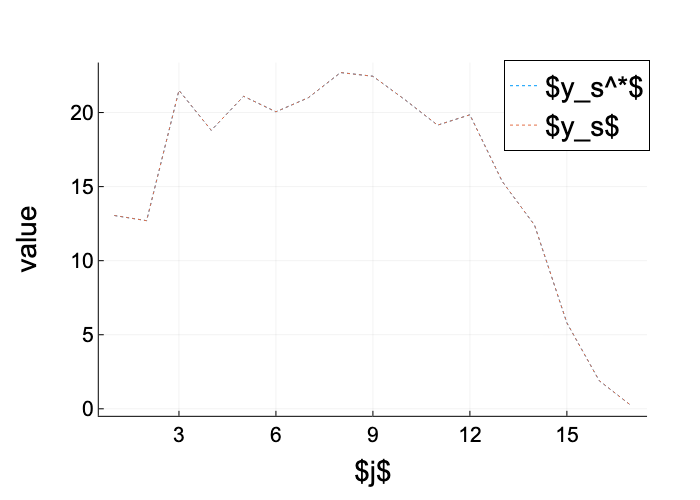

In [14]:
series_color = palette(:default)
fig = generate_empty(cc.bool_use_html)
plot!(
    1:n, yₛ,
    label=L"$y_s^*$",
    linewidth=1,
    linestyle=:dot,
)
plot!(
    1:n, r.y,
    label=L"$y_s$",
    linewidth=1,
    linestyle=:dot,
)
fig

## Dynamic control 

In [15]:
results = Dict()

Dict{Any, Any}()

In [16]:
revenue_candidates = Dict(
    "early" => [(n-i+2) for i in 1:n],
    "early2" => [(n-i+2)^1.5 for i in 1:n],
    "late" => [(i) for i in 1:n],
    "late2" => [(i)^2 for i in 1:n],
)

Dict{String, Vector} with 4 entries:
  "late2"  => [1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 2…
  "early"  => [18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2]
  "early2" => [76.3675, 70.0928, 64.0, 58.0948, 52.3832, 46.8722, 41.5692, 36.4…
  "late"   => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

### Run linear priority policy

In [22]:
default_barrier_option.μ = 5e-1
for (k, cvec) in revenue_candidates
    Fp(vec_z) = F!(
        vec_z, vec_Ψ;
        fₜ=Criminos.decision_priority_by_opt!, 
        targs=(
            mipar, default_decision_option,
            cvec, 0.1, 1.0, 0.25, δ
        ),
        fₘ=cc.style_mixin, 
        margs=_args,
    )
    kₑ, ε, traj, bool_opt = Criminos.simulate(
        vec_z, vec_Ψ, Fp; K=10000,
        metrics=metrics,
        tol=1e-7
    );
    # compare with knapsack rule
    # rkn = Criminos.decision_priority!(traj[end][1], vec_Ψ[1]; args=(cvec, 0.1, 1.0, 0.45, δ))
    # @info """sanity check 
    # $([rkn traj[end][1].I])
    # $(abs.(rkn - traj[end][1].I) |> maximum)
    # """
    results[k] = traj[end][1]
end

Progress:  11%|████▊                                    |  ETA: 0:00:40┌ Info: converged in 1163 steps
└ @ Criminos /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/src/Criminos.jl:195
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
┌ Info: final eps: 9.941893508807525e-8
└ @ Criminos /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/src/Criminos.jl:203
Progress:  11%|████▌                                    |  ETA: 0:00:35┌ Info: converged in 1120 steps
└ @ Criminos /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/src/Criminos.jl:195
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
┌ Info: final eps: 9.9556268561174e-8
└ @ Criminos /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/src/Criminos.jl:203
Progress:  11%|████▋    

In [24]:

default_barrier_option.μ = 5e-1
Fp(vec_z) = F!(
    vec_z, vec_Ψ;
    fₜ=Criminos.decision_priority_by_opt!, 
    targs=(
        mipar, default_decision_conic_option,
        cvec, 0.1, 1.0, 0.25, δ
    ),
    fₘ=cc.style_mixin, 
    margs=_args,
)
kₑ, ε, traj, bool_opt = Criminos.simulate(
    vec_z, vec_Ψ, Fp; K=10000,
    metrics=metrics,
    tol=1e-7
);
results["conic"] = traj[end][1]


Progress:   0%|                                         |  ETA: 1:42:06

MOSEK warning 705 (MSK_RES_WRN_ZEROS_IN_SPARSE_ROW): 11 (nearly) zero elements are specified in sparse row ''(17) of matrix 'A'.
MOSEK warning 705 (MSK_RES_WRN_ZEROS_IN_SPARSE_ROW): 1 (nearly) zero elements are specified in sparse row ''(17) of matrix 'A'.
MOSEK warning 705 (MSK_RES_WRN_ZEROS_IN_SPARSE_ROW): 1 (nearly) zero elements are specified in sparse row ''(17) of matrix 'A'.


Progress:  10%|████▎                                    |  ETA: 0:00:59┌ Info: converged in 1037 steps
└ @ Criminos /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/src/Criminos.jl:195
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
┌ Info: final eps: 9.931218959464335e-8
└ @ Criminos /Users/brent/Library/Mobile Documents/com~apple~CloudDocs/Documents/recherche/docs-fairness/Criminos.jl/src/Criminos.jl:203


@current iterate 17 states:
   x: [74.822, 63.7183, 96.2514, 70.2259, 77.4632, 67.4049, 68.7668, 69.4765, 64.6679, 57.7826, 55.2997, 53.8756, 40.091, 29.2249, 11.8417, 3.4477, 0.3761]
   x₋: [74.822, 63.7183, 96.2514, 70.2259, 77.4632, 67.4049, 68.7668, 69.4765, 64.6679, 57.7826, 55.2997, 53.8756, 40.091, 29.2249, 11.8417, 3.4477, 0.3761]
   ρ: [0.1553, 0.1776, 0.1991, 0.2388, 0.2431, 0.2656, 0.2728, 0.2923, 0.3103, 0.3226, 0.31, 0.3304, 0.343, 0.3805, 0.4389, 0.4986, 0.4717]
   y: [11.6195, 11.3149, 19.1646, 16.7706, 18.8298, 17.9036, 18.7619, 20.3052, 20.0633, 18.6426, 17.1427, 17.7988, 13.751, 11.119, 5.1976, 1.7192, 0.1774]
   ∑: 240.2814/904.7364
   τ: [0.2644, 0.2889, 0.2848, 0.3152, 0.3082, 0.322, 0.3205, 0.3277, 0.3405, 0.3436, 0.3415, 0.3377, 0.3559, 0.363, 0.4112, 0.4415, 0.5421]
   I: [0.1827, 0.2099, 0.2053, 0.2391, 0.2313, 0.2466, 0.245, 0.253, 0.2672, 0.2707, 0.2683, 0.2642, 0.2843, 0.2923, 0.3458, 0.3794, 0.4913]


In [25]:
fig = generate_empty(cc.bool_use_html)
plot!(
    1:n, r.y ./ r.x,
    labels=L"$\bar \rho$",
    fillalpha=0.3,
    linestyle=:dot,
    color=series_color[1],
    linewidth=3,
    legend=:outerbottomright
)
plot!(
    1:n, r.τ,
    labels=L"$\bar \tau$",
    fillalpha=0.3,
    linestyle=:dot,
    linewidth=3,
    color=series_color[1],
)

for (idk, (k, rt)) in enumerate(results)
    plot!(
        1:n, rt.y ./ rt.x,
        labels=L"$\rho_{\textrm{%$k}}$",
        linestyle=:dot,
        color=series_color[idk+1],
        linewidth=3,
    )
    plot!(
        1:n, rt.τ,
        labels=L"$\tau_{\textrm{%$k}}$",
        fillalpha=0.3,
        linestyle=:dot,
        color=series_color[idk+1],
        linewidth=3,
    )
end
savefig(fig, "test.html")

"/Users/brent/workspace/Criminos.jl/test.html"

In [ ]:
results["early"].ρ

In [ ]:
results["late"].τ

In [ ]:
sum(results["early"].x .* results["early"].τ)


In [ ]:
sum(r.x .* r.τ)